In [1]:
import brainpy as bp

bp.math.set_platform("cpu")

In [2]:
LIF = bp.neurons.LIF
Exponential = bp.synapses.Exponential

In [3]:
class EINet(bp.dyn.Network):
  def __init__(self, num_exc, num_inh, method='exp_auto', **kwargs):
    super(EINet, self).__init__(**kwargs)

    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
    E = LIF(num_exc, **pars, method=method)
    I = LIF(num_inh, **pars, method=method)
    E.V.value = bp.math.random.randn(num_exc) * 2 - 55.
    I.V.value = bp.math.random.randn(num_inh) * 2 - 55.

    # synapses
    w_e = 0.6  # excitatory synaptic weight
    w_i = 6.7  # inhibitory synaptic weight
    E_pars = dict(output=bp.synouts.COBA(E=0.), g_max=w_e, tau=5.)
    I_pars = dict(output=bp.synouts.COBA(E=-80.), g_max=w_i, tau=10.)
    
    # Neurons connect to each other randomly with a connection probability of 2%
    self.E2E = Exponential(E, E, bp.conn.FixedProb(prob=0.02), **E_pars, method=method)
    self.E2I = Exponential(E, I, bp.conn.FixedProb(prob=0.02), **E_pars, method=method)
    self.I2E = Exponential(I, E, bp.conn.FixedProb(prob=0.02), **I_pars, method=method)
    self.I2I = Exponential(I, I, bp.conn.FixedProb(prob=0.02), **I_pars, method=method)

    self.E = E
    self.I = I

  0%|          | 0/1000 [00:00<?, ?it/s]

Used time None s


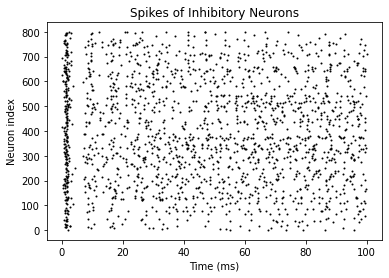

In [4]:
net = EINet(3200, 800, method='exp_auto')  # "method": the numerical integrator method

runner = bp.dyn.DSRunner(net,
                         monitors=['E.spike', 'I.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)])
t = runner.run(100.)
print(f'Used time {t} s')

# visualization
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'],
                         title='Spikes of Excitatory Neurons', show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'],
                         title='Spikes of Inhibitory Neurons', show=True)

In [5]:
# neurons
pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
E = LIF(3200, **pars)
I = LIF(800, **pars)
E.V.value = bp.math.random.randn(E.num) * 2 - 55.
I.V.value = bp.math.random.randn(I.num) * 2 - 55.

# synapses
E_pars = dict(output=bp.synouts.COBA(E=0.), g_max=0.6, tau=5.)
I_pars = dict(output=bp.synouts.COBA(E=-80.), g_max=6.7, tau=10.)
E2E = Exponential(E, E, bp.conn.FixedProb(prob=0.02), **E_pars)
E2I = Exponential(E, I, bp.conn.FixedProb(prob=0.02), **E_pars)
I2E = Exponential(I, E, bp.conn.FixedProb(prob=0.02), **I_pars)
I2I = Exponential(I, I, bp.conn.FixedProb(prob=0.02), **I_pars)


# Network
net2 = bp.dyn.Network(E2E, E2I, I2E, I2I, exc_group=E, inh_group=I)

In [13]:
class SNNModel(bp.dyn.DynamicalSystem):
  def __init__(self, num_in, num_rec, num_out):
    super(SNNModel, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out

    # neuron groups
    self.i = bp.neurons.InputGroup(num_in, mode=bp.modes.training)
    self.r = bp.neurons.LIF(num_rec, tau=10, V_reset=0, V_rest=0, V_th=1.,
                            mode=bp.modes.training)
    self.o = bp.neurons.LeakyIntegrator(num_out, tau=5, mode=bp.modes.training)

    # synapse: i->r
    self.i2r = bp.synapses.Exponential(self.i, self.r, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(), tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.),
                                       mode=bp.modes.training)
    # synapse: r->o
    self.r2o = bp.synapses.Exponential(self.r, self.o, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(), tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.),
                                       mode=bp.modes.training)

  def update(self, shared, spike):
    self.i2r(shared, spike)
    self.r2o(shared)
    self.r(shared)
    self.o(shared)
    return self.o.V.value

In [15]:
import numpy as np
import brainpy.math as bm

def current2firing_time(x, tau=20., thr=0.2, tmax=1.0, epsilon=1e-7):
  x = np.clip(x, thr + epsilon, 1e9)
  T = tau * np.log(x / (x - thr))
  T = np.where(x < thr, tmax, T)
  return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
  labels_ = np.array(y, dtype=bm.ditype())
  sample_index = np.arange(len(X))

  # compute discrete firing times
  tau_eff = 2. / bm.get_dt()
  unit_numbers = np.arange(nb_units)
  firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=bm.ditype())

  if shuffle:
    np.random.shuffle(sample_index)

  counter = 0
  number_of_batches = len(X) // batch_size
  while counter < number_of_batches:
    batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
    all_batch, all_times, all_units = [], [], []
    for bc, idx in enumerate(batch_index):
      c = firing_times[idx] < nb_steps
      times, units = firing_times[idx][c], unit_numbers[c]
      batch = bc * np.ones(len(times), dtype=bm.ditype())
      all_batch.append(batch)
      all_times.append(times)
      all_units.append(units)
    all_batch = np.concatenate(all_batch).flatten()
    all_times = np.concatenate(all_times).flatten()
    all_units = np.concatenate(all_units).flatten()
    x_batch = bm.zeros((batch_size, nb_steps, nb_units))
    x_batch[all_batch, all_times, all_units] = 1.
    y_batch = bm.asarray(labels_[batch_index])
    yield x_batch, y_batch
    counter += 1